In [1]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.utils import custom_object_scope
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
import cv2 as cv

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahanzabihi","key":"5cbdd7df400346293033c10cda2794b2"}'}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download -d ameyamote030/einterface-image-dataset

100% 799M/801M [00:38<00:00, 24.4MB/s]
100% 801M/801M [00:38<00:00, 21.7MB/s]


In [5]:
zip_ref = zipfile.ZipFile('einterface-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
train_path = '/content/eINTERFACE_2021_Image/train'
test_path = '/content/eINTERFACE_2021_Image/test'
valid_path = '/content/eINTERFACE_2021_Image/val'

In [7]:
categorys = {"Anger" : 0, "Disgust" : 1, "Fear" : 2, "Happiness" : 3, "Sadness" : 4, "Surprise" : 5}

In [8]:
x_train = []
y_train = []
dim = 128

for i in sorted(os.listdir(train_path)):
  path = os.path.join(train_path, i)
  for j in os.listdir(path):
    img = cv.imread(os.path.join(path, j), 0)
    img = cv.resize(img, (dim, dim))

    x_train.append(img)
    y_train.append(categorys[i])

In [9]:
x_test = []
y_test = []

for i in sorted(os.listdir(test_path)):
  path = os.path.join(test_path, i)
  for j in os.listdir(path):
    img = cv.imread(os.path.join(path, j), 0)
    img = cv.resize(img, (dim, dim))

    x_test.append(img)
    y_test.append(categorys[i])

In [10]:
x_val = []
y_val = []

for i in sorted(os.listdir(valid_path)):
  path = os.path.join(valid_path, i)
  for j in os.listdir(path):
    img = cv.imread(os.path.join(path, j), 0)
    img = cv.resize(img, (dim, dim))

    x_val.append(img)
    y_val.append(categorys[i])

In [11]:
x_train = np.array(x_train, dtype = 'float') / 255.0
x_test = np.array(x_test, dtype = 'float') / 255.0
x_val = np.array(x_val, dtype = 'float') / 255.0

In [12]:
x_val.shape

(1433, 128, 128)

In [13]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [14]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [15]:
x_train_r = x_train.reshape(x_train.shape[0], dim, dim, 1)
x_test_r = x_test.reshape(x_test.shape[0], dim, dim, 1)
x_val_r = x_val.reshape(x_val.shape[0], dim, dim, 1)

In [16]:
print(x_train_r.shape)
print(x_test_r.shape)
print(x_val_r.shape)

(11475, 128, 128, 1)
(1438, 128, 128, 1)
(1433, 128, 128, 1)


In [17]:
def build_model():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(32, (3,3), input_shape = (dim, dim, 1), padding = 'same', activation = 'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))

  model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))

  model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
  model.add(layers.MaxPooling2D(pool_size = (2,2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(1024, activation = 'relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(512, activation = 'relu'))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(6, activation = 'softmax'))

  model.summary()

  return model

In [18]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0         
                                                        

In [19]:
epochs = 50
lr = 0.01
deacy_rate = lr / epochs
momentum = 0.8
sgd = SGD(lr = lr, momentum=momentum, decay = deacy_rate)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])

In [22]:
model_h = model.fit(x_train_r, y_train, batch_size = 32, epochs = epochs,
                    validation_data = (x_val_r, y_val), callbacks = [callback])

Epoch 1/50
359/359 [==============================] - 36s 69ms/step - loss: 1.5546 - accuracy: 0.3418 - val_loss: 1.3270 - val_accuracy: 0.4843
Epoch 2/50
359/359 [==============================] - 23s 63ms/step - loss: 1.1066 - accuracy: 0.5570 - val_loss: 1.0781 - val_accuracy: 0.6420
Epoch 3/50
359/359 [==============================] - 23s 64ms/step - loss: 0.8077 - accuracy: 0.6869 - val_loss: 0.6978 - val_accuracy: 0.7446
Epoch 4/50
359/359 [==============================] - 23s 64ms/step - loss: 0.5926 - accuracy: 0.7771 - val_loss: 0.5237 - val_accuracy: 0.8102
Epoch 5/50
359/359 [==============================] - 23s 63ms/step - loss: 0.4562 - accuracy: 0.8303 - val_loss: 0.4371 - val_accuracy: 0.8514
Epoch 6/50
359/359 [==============================] - 22s 63ms/step - loss: 0.3633 - accuracy: 0.8697 - val_loss: 0.3846 - val_accuracy: 0.8618
Epoch 7/50
359/359 [==============================] - 23s 63ms/step - loss: 0.2799 - accuracy: 0.8980 - val_loss: 0.2943 - val_accuracy:

In [27]:
model.save("human-emotions.h5")

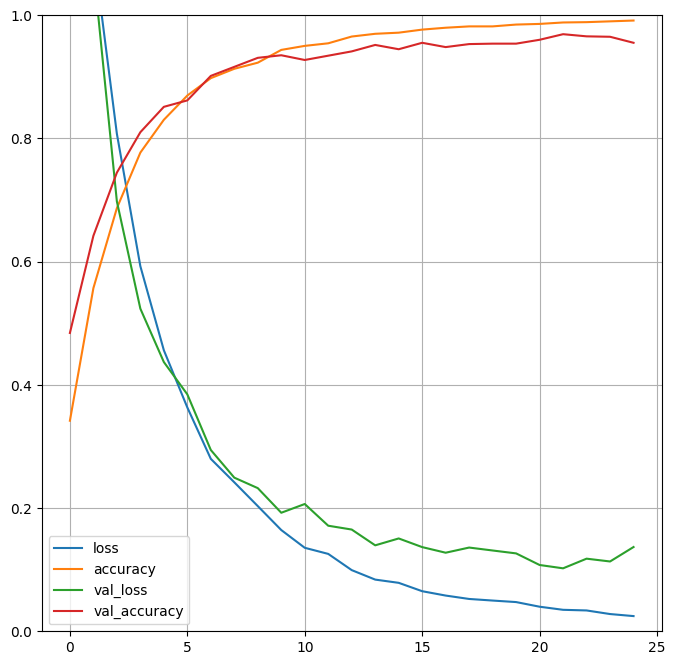

In [24]:
pd.DataFrame(model_h.history).plot(figsize = (8, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [25]:
model.evaluate(x_test_r, y_test)

45/45 [==============================] - 1s 25ms/step - loss: 0.1457 - accuracy: 0.9576


[0.14571736752986908, 0.9575799703598022]

In [28]:
from keras.models import load_model
model = load_model("human-emotions.h5")

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


45/45 [==============================] - 1s 12ms/step


Text(95.72222222222221, 0.5, 'Truth')

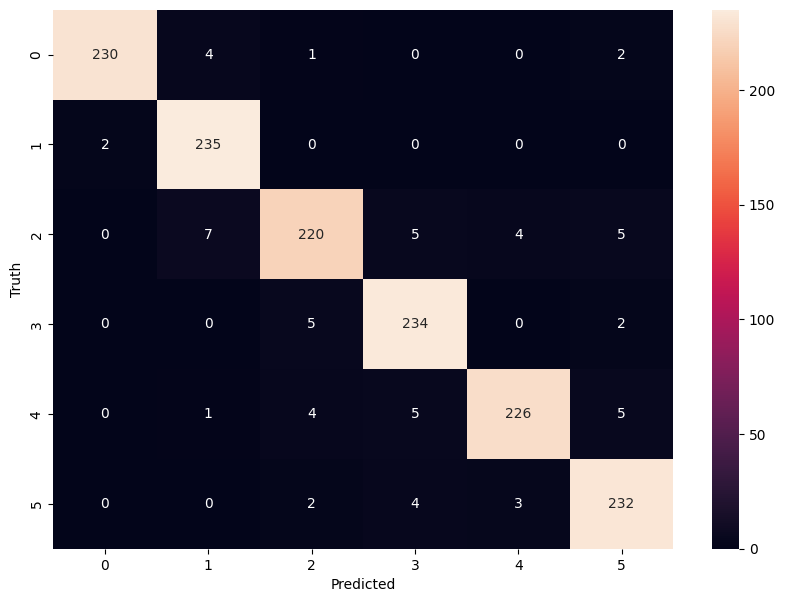

In [30]:
y_predicted = model.predict(x_test_r)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_test_categorical = tf.argmax(y_test, axis=1)

cm = tf.math.confusion_matrix(labels=y_test_categorical, predictions=y_predicted_labels)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')